In [53]:
import gym
# from pgm.common.utils import mini_batch_train
# from pgm.a2c.a2c import  A2CAgent # import agent from algorithm of interest
import tensorflow as tf
import numpy as np
import gym  #requires OpenAI gym installed
import matplotlib.pyplot as plt
import numpy as np
%timeit

In [54]:
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'bipedal-walker-v2': gym.make('BipedalWalker-v2')

}

In [67]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [55]:


################################################################
#sample from state space for state normalization
# import sklearn
# import sklearn.preprocessing
                                    
# state_space_samples = np.array(
#     [env.observation_space.sample() for x in range(10000)])
# scaler = sklearn.preprocessing.StandardScaler()
# scaler.fit(state_space_samples)

# #function to normalize states
# def scale_state(state):                 #requires input shape=(2,)
#     scaled = scaler.transform([state])
#     return scaled                       #returns shape =(1,2)   
###################################################################

In [ ]:
env = envs["bipedal-walker-v2"]

tf.reset_default_graph()

input_dims = 24
state_placeholder = tf.placeholder(tf.float32, [None, input_dims]) 

def value_function(state):
    n_hidden1 = 400  
    n_hidden2 = 400
    n_outputs = 1
    
    with tf.variable_scope("value_network"):
        init_xavier = tf.contrib.layers.xavier_initializer()
        
        hidden1 = tf.layers.dense(state, n_hidden1, tf.nn.elu, init_xavier)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, tf.nn.elu, init_xavier) 
        V = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
    return V


def policy_network(state, n_outputs = 4):
    n_hidden1 = 40
    n_hidden2 = 40
    
    with tf.variable_scope("policy_network"):
        init_xavier = tf.contrib.layers.xavier_initializer()
        
        hidden1 = tf.layers.dense(state, n_hidden1, tf.nn.elu, init_xavier)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, tf.nn.elu, init_xavier)
        mu = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
        sigma = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
        sigma = tf.nn.softplus(sigma) + 1e-5
        norm_dist = tf.contrib.distributions.Normal(mu, sigma)
        action_tf_var = tf.squeeze(norm_dist.sample(1), axis=0)
        action_tf_var = tf.clip_by_value(
            action_tf_var, env.action_space.low[0], 
            env.action_space.high[0])
    return action_tf_var, norm_dist

lr_actor = 0.00002  #set learning rates
lr_critic = 0.001

# define required placeholders
action_placeholder = tf.placeholder(tf.float32)
delta_placeholder = tf.placeholder(tf.float32)
target_placeholder = tf.placeholder(tf.float32)

action_tf_var, norm_dist = policy_network(state_placeholder)
V = value_function(state_placeholder)

# define actor (policy) loss function
loss_actor = -tf.log(norm_dist.prob(action_placeholder) + 1e-5) * delta_placeholder
training_op_actor = tf.train.AdamOptimizer(
    lr_actor, name='actor_optimizer').minimize(loss_actor)

# define critic (state-value) loss function
loss_critic = tf.reduce_mean(tf.squared_difference(
                             tf.squeeze(V), target_placeholder))
training_op_critic = tf.train.AdamOptimizer(
        lr_critic, name='critic_optimizer').minimize(loss_critic)
################################################################
#Training loop
gamma = 0.99        #discount factor
num_episodes = 500
loss_critic_vals = []
loss_actor_vals = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    episode_history = []
    for episode in range(num_episodes):
        #receive initial state from E
        state = env.reset()   # state.shape -> (2,)
        reward_total = 0 
        steps = 0
        done = False
        while (not done):
                
            #Sample action according to current policy
            #action.shape = (1,4)
            action  = sess.run(action_tf_var, feed_dict={
                          state_placeholder: scale_state(state)})
            #Execute action and observe reward & next state from E
            # next_state shape=(2,)    
            #env.step() requires input shape = (1,)
            next_state, reward, done, _ = env.step(
                                    np.squeeze(action, axis=0)) 
            steps +=1
            reward_total += reward
            #V_of_next_state.shape=(1,1)
            V_of_next_state = sess.run(V, feed_dict = 
                    {state_placeholder: scale_state(next_state)})  
            #Set TD Target
            #target = r + gamma * V(next_state)     
            target = reward + gamma * np.squeeze(V_of_next_state) 
            
            # td_error = target - V(s)
            #needed to feed delta_placeholder in actor training
            td_error = target - np.squeeze(sess.run(V, feed_dict = 
                        {state_placeholder: scale_state(state)})) 
            
            #Update actor by minimizing loss (Actor training)
            _, loss_actor_val  = sess.run(
                [training_op_actor, loss_actor], 
                feed_dict={action_placeholder: np.squeeze(action), 
                state_placeholder: scale_state(state), 
                delta_placeholder: td_error})
            #Update critic by minimizinf loss  (Critic training)
            _, loss_critic_val  = sess.run(
                [training_op_critic, loss_critic], 
                feed_dict={state_placeholder: scale_state(state), 
                target_placeholder: target})
            loss_critic_vals.append(loss_critic_val)
            loss_actor_vals.append(loss_actor_val)

            
            state = next_state
            #end while
        episode_history.append(reward_total)
        print("Episode: {}, Number of Steps : {}, Cumulative reward: {:0.2f}".format(
            episode, steps, reward_total))
        
#         if np.mean(episode_history[-100:]) > 90 and len(episode_history) >= 101:
#             print("****************Solved***************")
#             print("Mean cumulative reward over 100 episodes:{:0.2f}" .format(
#                 np.mean(episode_history[-100:])))

Episode: 0, Number of Steps : 1600, Cumulative reward: -101.42
Episode: 1, Number of Steps : 1600, Cumulative reward: -98.71
Episode: 2, Number of Steps : 1600, Cumulative reward: -96.78
Episode: 3, Number of Steps : 1600, Cumulative reward: -98.54
Episode: 4, Number of Steps : 1600, Cumulative reward: -87.45
Episode: 5, Number of Steps : 1600, Cumulative reward: -89.04
Episode: 6, Number of Steps : 76, Cumulative reward: -101.76
Episode: 7, Number of Steps : 1600, Cumulative reward: -98.90
Episode: 8, Number of Steps : 1600, Cumulative reward: -86.73
Episode: 9, Number of Steps : 1600, Cumulative reward: -88.70
Episode: 10, Number of Steps : 56, Cumulative reward: -99.43
Episode: 11, Number of Steps : 116, Cumulative reward: -111.05
Episode: 12, Number of Steps : 1600, Cumulative reward: -76.28
Episode: 13, Number of Steps : 91, Cumulative reward: -124.20
Episode: 14, Number of Steps : 91, Cumulative reward: -99.92
Episode: 15, Number of Steps : 79, Cumulative reward: -104.01
Episode:

Episode: 132, Number of Steps : 1600, Cumulative reward: -133.27
Episode: 133, Number of Steps : 1600, Cumulative reward: -123.56
Episode: 134, Number of Steps : 1600, Cumulative reward: -111.79
Episode: 135, Number of Steps : 1600, Cumulative reward: -103.53
Episode: 136, Number of Steps : 169, Cumulative reward: -127.95
Episode: 137, Number of Steps : 77, Cumulative reward: -101.51
Episode: 138, Number of Steps : 76, Cumulative reward: -106.68
Episode: 139, Number of Steps : 84, Cumulative reward: -108.14
Episode: 140, Number of Steps : 1600, Cumulative reward: -107.11
Episode: 141, Number of Steps : 130, Cumulative reward: -128.95
Episode: 142, Number of Steps : 1600, Cumulative reward: -113.56
Episode: 143, Number of Steps : 111, Cumulative reward: -111.34
Episode: 144, Number of Steps : 1600, Cumulative reward: -122.01
Episode: 145, Number of Steps : 168, Cumulative reward: -132.83
Episode: 146, Number of Steps : 1600, Cumulative reward: -129.07
Episode: 147, Number of Steps : 146

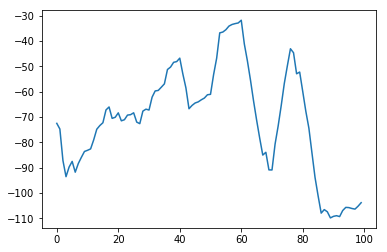

In [69]:
# plt.plot(rolling_average(np.array(episode_history), window_size=10))